In [22]:
# Parameters
NODE_SIZES = [200, 500]  # number of nodes
ER_PS = [0.02, 0.05]    # ER: edge probability
BA_MS = [3, 5]       # BA: edges to attach per new node
WS_K = 4
WS_BETAS = [0.1, 0.3]  # WS: rewiring probability
N_RUNS = 3     # how many runs to average per curve

In [23]:
# Import modules
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# make the plots look nice
plt.rcParams["figure.figsize"] = (6, 4)

Nodes: 100, Edges: 224


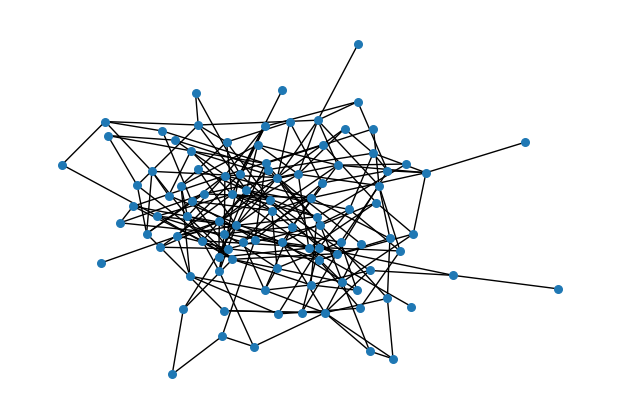

In [24]:
# Generate a sample graph
# Erdos-Renyi graph: n=100 nodes, edge probability=0.05
G = nx.erdos_renyi_graph(100, 0.05, seed=42)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
nx.draw(G, node_size=30, with_labels=False)
plt.show()

In [25]:
# Define functions
def largest_component_size(G):
    """Returns the size of the largest connected component as a fraction of nodes"""
    if G.number_of_nodes() == 0:
        return 0
    return len(max(nx.connected_components(G), key=len)) / G.number_of_nodes()

def simulate_removal(G, strategy="random"):
    """Removes nodes one by one and records giant component size
    strategy: "random" or "degree" """
    # copy graph to preserve original
    H = G.copy()
    sizes = [largest_component_size(H)]

    if strategy == "random":
        nodes = list(H.nodes())
        np.random.shuffle(nodes)
    elif strategy == "degree":
        # sorts nodes by degree decreasing
        nodes = sorted(H.degree, key=lambda x: x[1], reverse=True)
        nodes = [n for n, d in nodes]
    else:
        raise ValueError("Unknown strategy")

    for node in nodes:
        H.remove_node(node)
        sizes.append(largest_component_size(H))

    return sizes

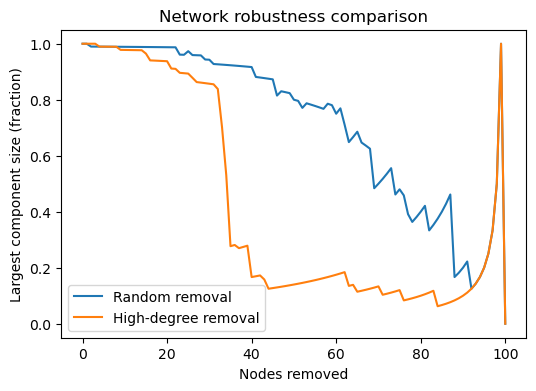

In [26]:
# Test random vs degree-based removal
random_curve = simulate_removal(G, strategy="random")
degree_curve = simulate_removal(G, strategy="degree")

plt.plot(random_curve, label="Random removal")
plt.plot(degree_curve, label="High-degree removal")
plt.xlabel("Nodes removed")
plt.ylabel("Largest component size (fraction)")
plt.legend()
plt.title("Network robustness comparison")
plt.show()

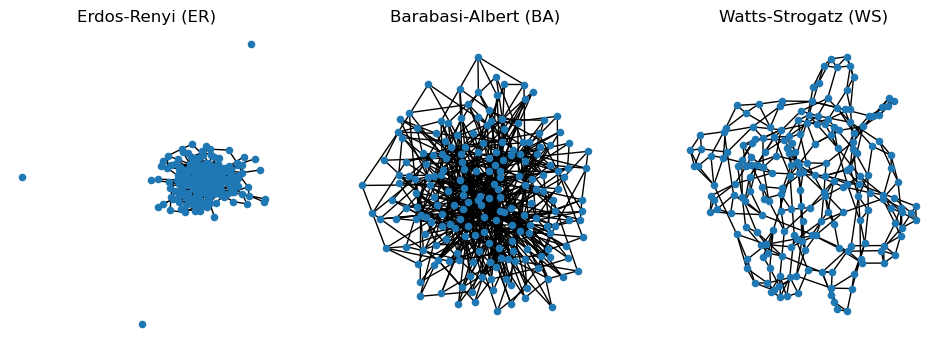

In [27]:
# Add graph generaters with new graph types

def er_graph(n, p):
    return nx.erdos_renyi_graph(n, p)

def ba_graph(n, m):
    return nx.barabasi_albert_graph(n, m)

def ws_graph(n, k, beta):
    return nx.watts_strogatz_graph(n, k, beta)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

nx.draw(er_graph(NODE_SIZES[0], ER_PS[0]), ax=axs[0], node_size=20, with_labels=False)
axs[0].set_title("Erdos-Renyi (ER)")

nx.draw(ba_graph(NODE_SIZES[0], BA_MS[0]), ax=axs[1], node_size=20, with_labels=False)
axs[1].set_title("Barabasi-Albert (BA)")

nx.draw(ws_graph(NODE_SIZES[0], WS_K, WS_BETAS[0]), ax=axs[2], node_size=20, with_labels=False)
axs[2].set_title("Watts-Strogatz (WS)")

plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:31<00:00, 47.11it/s]


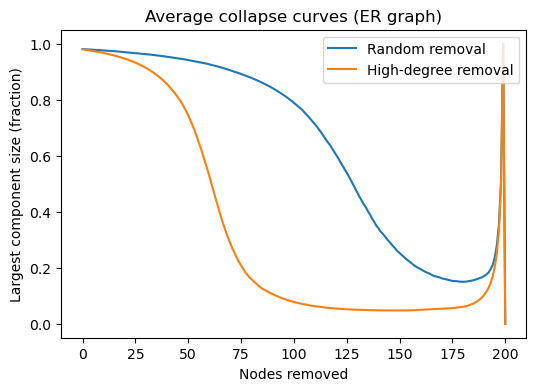

In [28]:
# Repeat experiments for averages
def average_curve(G_generator, n_runs=10, strategy="random"):
    """Runs multiple simulations and averages the results"""
    curves = []
    for _ in tqdm(range(n_runs)):
        G = eval(G_generator + ')')
        sizes = simulate_removal(G, strategy=strategy)
        curves.append(sizes)
    # pad shorter curves with zeros
    max_len = max(len(c) for c in curves)
    curves = [c + [0]*(max_len - len(c)) for c in curves]
    return np.mean(curves, axis=0)

# Example: compare random vs degree removal on ER graphs
n = 200
p = 0.02

random_avg = average_curve('er_graph(n, p', strategy="random", n_runs=1500)
degree_avg = average_curve('er_graph(n, p', strategy="degree", n_runs=1500)

plt.plot(random_avg, label="Random removal")
plt.plot(degree_avg, label="High-degree removal")
plt.xlabel("Nodes removed")
plt.ylabel("Largest component size (fraction)")
plt.legend()
plt.title("Average collapse curves (ER graph)")
plt.show()

In [31]:
# Compare network robustness between models
models = {
    "ER": 'er_graph(NODE_SIZES[0], ER_PS[0]',
    "BA": 'ba_graph(NODE_SIZES[0], BA_MS[0]',
    "WS": 'ws_graph(NODE_SIZES[0], WS_K, WS_BETAS[0]',
}

strategies = ["random", "degree"]

results = {}

for model_name, gen in models.items():
    for strat in strategies:
        avg_curve = average_curve(gen, n_runs=N_RUNS, strategy=strat)
        results[(model_name, strat)] = avg_curve

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 60.04it/s]


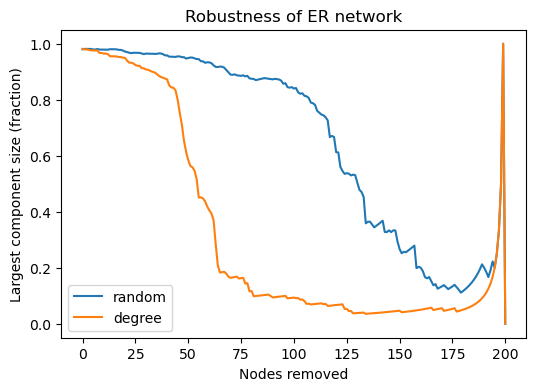

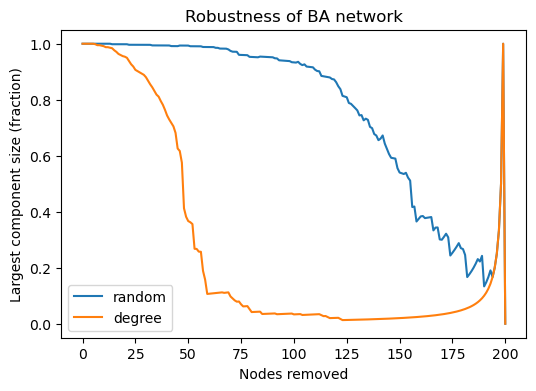

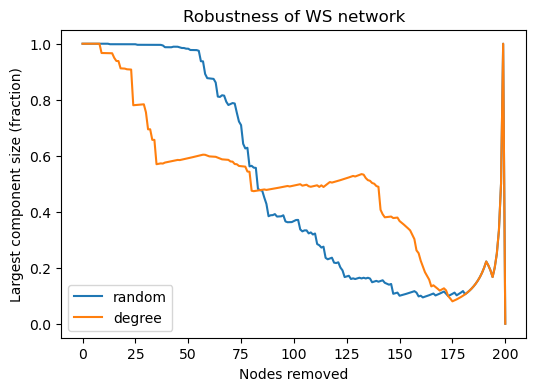

In [32]:
# Compare plots by model
for model_name in models:
    plt.figure(figsize=(6, 4))
    for strat in strategies:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=strat)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Robustness of {model_name} network")
    plt.legend()
    plt.show()

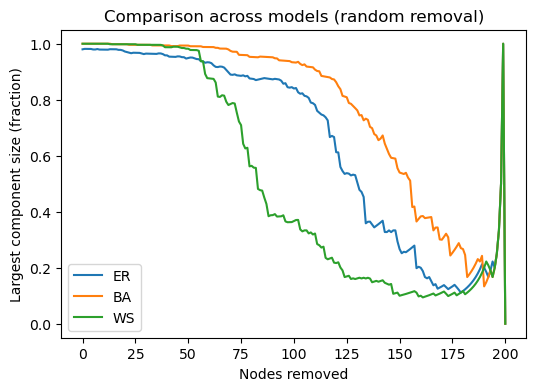

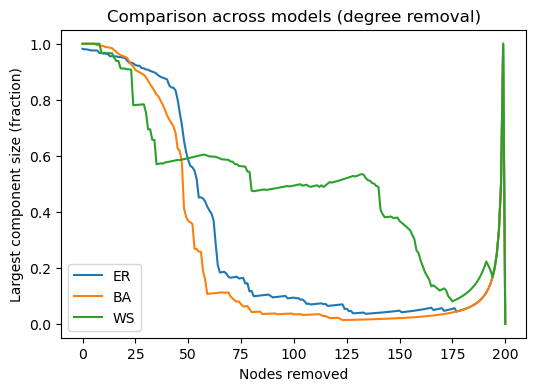

In [33]:
# Compare plots by strategy
for strat in strategies:
    plt.figure(figsize=(6, 4))
    for model_name in models:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=model_name)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Comparison across models ({strat} removal)")
    plt.legend()
    plt.show()

In [34]:
from sklearn.metrics import auc

# Function to compute robustness score (AUC)
def robustness_score(curve):
    """ curve: list of largest component fractions as nodes are removed. returns
    normalized area under the curve (0-1) """
    x = np.linspace(0, 1, len(curve))  # fraction of nodes removed
    score = auc(x, curve) / 1.0  # normalized for a max of 1
    return score

In [36]:
import pandas as pd

# Compute robustness scores for all models and strategies with all parameters
batch_results = []

for n in NODE_SIZES:
    for p in ER_PS:
        for strat in strategies:
            curve = average_curve('er_graph(n, p', n_runs=N_RUNS, strategy=strat)
            score = robustness_score(curve)
            batch_results.append(["ER", strat, n, p, None, None, score])
    for m in BA_MS:
        for strat in strategies:
            curve = average_curve('ba_graph(n, m', n_runs=N_RUNS, strategy=strat)
            score = robustness_score(curve)
            batch_results.append(["BA", strat, n, None, m, None, score])
    for beta in WS_BETAS:
        for strat in strategies:
            curve = average_curve('ws_graph(n, WS_K, beta', n_runs=N_RUNS, strategy=strat)
            score = robustness_score(curve)
            batch_results.append(["WS", strat, n, None, None, beta, score])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.31it/s]


In [37]:
import os

# Create results directory
os.makedirs("results", exist_ok=True)

In [40]:
# Save strategy and model comparisons
for model_name in models:
    plt.figure(figsize=(6, 4))
    for strat in strategies:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=strat)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"{model_name} robustness (N={NODE_SIZES[0]})")
    plt.legend()
    filename = f"results/{model_name}_N{NODE_SIZES[0]}_robustness.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

for strat in strategies:
    plt.figure(figsize=(6, 4))
    for model_name in models:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=model_name)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Comparison across models ({strat} removal)")
    plt.legend()
    filename = f"results/comparison_{strat}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [41]:
# Save robustness scores
df_batch = pd.DataFrame(batch_results, columns=[
    "Model", "Strategy", "N", "ER_p", "BA_m", "WS_beta", "RobustnessScore"
])

df_batch.to_csv("results/batch_results.csv", index=False)
df_batch

,Model,Strategy,N,ER_p,BA_m,WS_beta,RobustnessScore
0,ER,random,200,0.02,NaN,NaN,0.639833
1,ER,degree,200,0.02,NaN,NaN,0.369549
2,ER,random,200,0.05,NaN,NaN,0.869769
3,ER,degree,200,0.05,NaN,NaN,0.705015
4,BA,random,200,NaN,3.0,NaN,0.760049
5,BA,degree,200,NaN,3.0,NaN,0.291461
6,BA,random,200,NaN,5.0,NaN,0.881526
7,BA,degree,200,NaN,5.0,NaN,0.472751
8,WS,random,200,NaN,NaN,0.1,0.521214
9,WS,degree,200,NaN,NaN,0.1,0.490997
